# WHONDRS data preprocessing notebook

We want to predict sediment respiration rates based on:
1. site data (in situ water samples - isotopes, chemical conc./presence)
2. intermediate scale data (site metadata, e.g. what an observer sees)
3. large scale data (satellite data, stream order)

This notebook will preprocess the WHONDRS data for use with machine learning. 
In this case, preprocessing means pulling out exactly the data to be used 
and applying any reformatting/reordering needed to create a single input file 
for the machine learning.

There are multiple respiration rates per site because they come from
upstream, midstream, and downstream sampling locations.  Some site
metadata encompass the whole site and other metadata are specific to
the U, M, and D "subsites".  Here, we attempt to keep U, M, and D
data points as separate as possible.

The data sets merged here are:
1. WHONDRS **sediment** respiration rate (the target variable for predictions), 
2. WHONDRS site metadata (range of scales, recorded by observers),
3. WHONDRS **sediment** FTICR chemical presence/absence,
4. WHONDRS site data (isotopes, C and N percentages, flow cytometry, grain size, and NPOC).

(#1 and #2 are already pre-merged).

Large scale data from RiverATLAS (stream order, water depth, climatic and land use
indices) are merged separately during ML workflow execution. This additional
merge is carried out seprately because it draws on data outside of WHONDRS while
all data merged here are WHONDRS S19S data.  WHONDRS S19S has a broader range of input
variables (i.e. features) than subsequent WHONDRS ICON-ModEx and SSS sampling.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

# Full path of directory that contains WHONDRS data
csv_path = "~/global-river-databases/WHONDRS/"

# Load respiration rate and site observer metadata

Respiration rate will be the key output of the ML models.  The presence/absence of data from each site in this data set determines all other record queries.

In [2]:
# Load the metadata (md) and 
# respiration rate (rr) data.
# Here, the Sample_ID can be used 
# to access a whole sample, e.g.:
# df_site_meta.loc['S19S_0001-U',:]
df_md_rr = pd.read_csv(
    csv_path+"ICON-ModEx_Data.csv",
    index_col='Sample_ID',
    header=0)

# Set a dictionary with the variables to be used
# (the column name in the file) and the data type.
md_rr_data_to_use = {
    'Sample_Longitude':np.dtype('float'),
    'Sample_Latitude':np.dtype('float'), 
    #'Sample_Kit_ID', # Not unique; use Sample_ID as DF index
    #'Date', 
    #'Median_Time_Unix', 
    #'Median_Time_Local',
    #'Local_Timezone',
    'Mean_DO_mg_per_L':np.dtype('float'),
    #'DO_sd',
    'Mean_DO_percent_saturation':np.dtype('float'),
    #'DO_percent_saturation_sd',
    'Mean_Temp_Deg_C':np.dtype('float'),
    #'Temp_sd',
    #'Respiration_Rate_mg_DO_per_L_per_H':np.dtype('float'), # Highly correlated with Norm. RR below
    'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment':np.dtype('float'), 
    #'Type',
    #'Respiration_R_Squared':np.dtype('float'),      # Drop the data associated with the respiration rate
    #'Respiration_R_Squared_Adj':np.dtype('float'),  # since they only apply to situations where we actually
    #'Respiration_p_value':np.dtype('float'),        # have the respiration rate, which defeats the point of
    #'Total_Incubation_Time_Min':np.dtype('float'),  # making ML predictions of respiration rate.
    #'Number_Points_In_Respiration_Regression':np.dtype('float'),
    #'Number_Points_Removed_Respiration_Regression':np.dtype('float'),
    #'DO_Concentration_At_Incubation_Time_Zero':np.dtype('float'),  # Highly correlated with RR, normalized
    #'Site_ID', # Not unique for each row; use Sample_ID as DF index.
    #'MiniDot_Latitude',
    #'MiniDot_Longitude', 
    #'MiniDot_Start_Time', 
    #'MiniDot_End_Time',
    #'MiniDot_ID', 
    'pH':np.dtype('float'), 
    #'Contact_First_Name', 
    #'Contact_Last_Name',
    #'Organization', 
    #'Email', 
    #'Site_Name', 
    #'Stream_Name', 
    #'City', 
    #'State',
    #'Country', 
    #'Weather', 
    'Intermittent_or_Perennial':'category', 
    'General_Vegetation':'category',
    'Hydrogeomorphology':'category', 
    'River_Gradient':'category', 
    'MiniDot_Sediment':'category',
    #'Water_Temperature':np.dtype('float'), # String values, duplicate of Mean_Temp_Deg_C?
    'Water_Depth_cm':np.dtype('float'), 
    'Depositional_Type':'category',
    'Canopy_Cover':'category', 
    'Macrophyte_Coverage':'category', 
    'Algal_Mat_Coverage':'category',
    #'Sediment_Collection_Depth_cm':np.dtype('float'), # Does not appear to have any data for S19S
    #'MiniDot_Notes',
    #'Additional_Sampling_Notes', 
    #'Hydrograph_Online', 
    #'Hydrograph_Other',
    #'Water_volume_Flag', 
    #'Notes'
}

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# If there are any missing respiration rates, drop whole rows from the very beginning:
print('Starting with DF shape: '+str(df_md_rr.shape))

print('Retaining only S19S and SSS data...')
df_md_rr = df_md_rr.filter(axis='index', regex="S19S|SSS")

# Remove any internal commas in gradient and vegetation type
# For example, "e.g., " becomes "e.g." and
# "Grass, Shrub" becomes "Grass. Shrub".
df_md_rr['River_Gradient'] = df_md_rr['River_Gradient'].replace(',','',regex=True)
df_md_rr['General_Vegetation'] = df_md_rr['General_Vegetation'].replace(',','.',regex=True)

print('Current DF shape: '+str(df_md_rr.shape))
print('Dropping any NaN (missing) normalized respiration rates...')
df_md_rr.dropna(axis='index', subset=['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'], 
                how='any', inplace=True)
print('Current DF shape: '+str(df_md_rr.shape))

# Negative values for certain columns are replaced with nan
df_md_rr[
    df_md_rr.loc[:,[
        'Respiration_R_Squared', 
        'Respiration_R_Squared_Adj', 
        'Respiration_p_value', 
        'Total_Incubation_Time_Min',
        'Number_Points_In_Respiration_Regression',
        'Number_Points_Removed_Respiration_Regression']] < 0] = np.nan 
df_md_rr

Starting with DF shape: (699, 58)
Retaining only S19S and SSS data...
Current DF shape: (435, 58)
Dropping any NaN (missing) normalized respiration rates...
Current DF shape: (367, 58)


,Sample_Kit_ID,Date,Median_Time_Unix,Median_Time_Local,Local_Timezone,Mean_DO_mg_per_L,DO_sd,Mean_DO_percent_saturation,DO_percent_saturation_sd,Mean_Temp_Deg_C,Temp_sd,Respiration_Rate_mg_DO_per_L_per_H,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment,Type,Respiration_R_Squared,Respiration_R_Squared_Adj,Respiration_p_value,Total_Incubation_Time_Min,Number_Points_In_Respiration_Regression,Number_Points_Removed_Respiration_Regression,DO_Concentration_At_Incubation_Time_Zero,Site_ID,Sample_Latitude,Sample_Longitude,MiniDot_Latitude,MiniDot_Longitude,MiniDot_Start_Time,MiniDot_End_Time,MiniDot_ID,pH,Contact_First_Name,Contact_Last_Name,Organization,Email,Site_Name,Stream_Name,City,State,Country,Weather,Intermittent_or_Perennial,General_Vegetation,Hydrogeomorphology,River_Gradient,MiniDot_Sediment,Water_Temperature,Water_Depth_cm,Depositional_Type,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,Sediment_Collection_Depth_cm,MiniDot_Notes,Additional_Sampling_Notes,Hydrograph_Online,Hydrograph_Other,Water_volume_Flag,Notes
Sample_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SSS001-1,SSS001,2022-08-08,1.659979e+09,09:18:30,Pacific Standard Time (UTC-8),9.31,0.04,93.99,0.27,15.84,0.34,-564.80,-2236.81,Theoretical,NaN,NaN,NaN,NaN,NaN,NaN,3.793333,S63,46.04170,-120.57310,46.0416,-120.57320,08:53:00,09:49:00,654896.0,8.18,James,Stegen,PNNL,james.stegen@pnnl.gov,S63P,NaN,NaN,Washington,USA,Sunny,Perennial,Broadleaf deciduous tree. Grass,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),15.33,41.0,NaN,Low (5-30%),Low (5-30%),NaN,1-3 cm as described in the protocol,NaN,NaN,NaN,NaN,False,NaN
SSS001-2,SSS001,2022-08-08,1.659979e+09,09:18:30,Pacific Standard Time (UTC-8),9.31,0.04,93.99,0.27,15.84,0.34,-1012.40,-3827.24,Theoretical,NaN,NaN,NaN,NaN,NaN,NaN,0.063333,S63,46.04170,-120.57310,46.0416,-120.57320,08:53:00,09:49:00,654896.0,8.18,James,Stegen,PNNL,james.stegen@pnnl.gov,S63P,NaN,NaN,Washington,USA,Sunny,Perennial,Broadleaf deciduous tree. Grass,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),15.33,41.0,NaN,Low (5-30%),Low (5-30%),NaN,1-3 cm as described in the protocol,NaN,NaN,NaN,NaN,False,NaN
SSS001-3,SSS001,2022-08-08,1.659979e+09,09:18:30,Pacific Standard Time (UTC-8),9.31,0.04,93.99,0.27,15.84,0.34,-1006.80,-3800.03,Theoretical,NaN,NaN,NaN,NaN,NaN,NaN,0.110000,S63,46.04170,-120.57310,46.0416,-120.57320,08:53:00,09:49:00,654896.0,8.18,James,Stegen,PNNL,james.stegen@pnnl.gov,S63P,NaN,NaN,Washington,USA,Sunny,Perennial,Broadleaf deciduous tree. Grass,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),15.33,41.0,NaN,Low (5-30%),Low (5-30%),NaN,1-3 cm as described in the protocol,NaN,NaN,NaN,NaN,False,NaN
SSS002-1,SSS002,2022-08-08,1.659987e+09,11:23:30,Pacific Standard Time (UTC-8),9.73,0.02,108.23,0.61,20.57,0.33,-1.60,-5.81,Measured_10mL,0.994000,0.993000,0.000833,120.0,8.0,0.0,8.553333,S30R,46.09590,-120.54760,46.096,-120.54760,10:58:00,11:54:00,809246.0,8.45,James,Stegen,PNNL,james.stegen@pnnl.gov,S30R,NaN,NaN,Washington,USA,Sunny,Perennial,Broadleaf deciduous tree. Shrub,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),20.58,7.5,NaN,Med (30-70%),Low (5-30%),Med (30-70%),1-3 cm as described in the protocol,NaN,NaN,NaN,NaN,False,NaN
SSS002-2,SSS002,2022-08-08,1.659987e+09,11:23:30,Pacific Standard Time (UTC-8),9.73,0.02,108.23,0.61,20.57,0.33,-1.50,-5.53,Measured_10mL,0.962000,0.956000,0.002030,120.0,8.0,0.0,8.310000,S30R,46.09590,-120.54760,46.096,-120.54760,10:58:00,11:54:00,809246.0,8.45,James,Stegen,PNNL,james.stegen@pnnl.gov,S30R,NaN,NaN,Washington,USA,Sunny,Perennial,Broadleaf deciduous tree. Shrub,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),20.58,7.5,NaN,Med (30-70%),Low (5-30%),Med (30-70%),1-3 cm as described in the protocol,NaN,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,.

# Load sample isotope, NPOC, grain size, flow cytometry, and CN data

In [3]:
df_isotopes = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_Isotopes.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
isotopes_data_to_use = {
    'del_15N_permil':np.dtype('float'),
    'del_13C_permil':np.dtype('float')
}

# Drop the Study_Code from this and all following datasets
# since this duplicated information can cause merge issues later.
df_isotopes.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_isotopes.replace(to_replace=-9999, value=np.nan, inplace=True)

df_isotopes

,del_15N_permil,del_13C_permil,Date_Run
Sample_ID,,,
S19S_0001-D,1.23,-22.06,2022-10-24
S19S_0001-M,-1.28,-26.27,2022-10-24
S19S_0001-U,1.77,-23.20,2022-10-24
S19S_0003-D,2.61,-26.03,2022-10-24
S19S_0003-M,4.91,-25.32,2022-10-24
...,...,...,...
S19S_0099-M,-7.42,-2.45,2022-10-24
S19S_0099-U,-4.55,-0.70,2022-10-24
S19S_0100-D,4.82,-16.68,2022-10-24


In [4]:
df_npoc_inc = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_NPOC_INC.csv.adj",
    header=0,
    index_col='Sample_ID')

df_npoc_field = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_NPOC_Field.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
npoc_inc_data_to_use = {
    'NPOC_INC_mg_per_L_as_C':np.dtype('float')
}

npoc_field_data_to_use = {
    'NPOC_Field_mg_per_L_as_C':np.dtype('float')
}

df_npoc_inc.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_npoc_inc.replace(to_replace=-9999, value=np.nan, inplace=True)

df_npoc_inc

,NPOC_INC_mg_per_L_as_C
Sample_ID,
S19S_0044-M,14.77
S19S_0016-D,5.72
S19S_0015-D,11.21
S19S_0050-D,7.15
S19S_0032-D,25.64
...,...
S19S_0075-U,8.28
S19S_0055-U,18.88
S19S_0042-M,27.92


In [5]:
df_npoc_field.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_npoc_field.replace(to_replace=-9999, value=np.nan, inplace=True)

df_npoc_field

,NPOC_Field_mg_per_L_as_C
Sample_ID,
S19S_0067-D,24.32
S19S_0072-M,8.90
S19S_0073-U,20.24
S19S_0071-U,31.58
S19S_0064-M,21.81
...,...
S19S_0087-U,25.61
S19S_0067-U,46.59
S19S_0094-D,7.57


In [6]:
df_grainsize = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_GrainSize.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
grainsize_data_to_use = {
    'Percent_Fine_Sand':np.dtype('float'),
    'Percent_Med_Sand':np.dtype('float'),
    'Percent_Coarse_Sand':np.dtype('float'),
    'Percent_Tot_Sand':np.dtype('float'),
    'Percent_Clay':np.dtype('float'),
    'Percent_Silt':np.dtype('float')
}

df_grainsize.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_grainsize.replace(to_replace=-9999, value=np.nan, inplace=True)

df_grainsize

,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt
Sample_ID,,,,,,
S19S_0001-D,21.1,69.7,0.1,90.9,0.0,9.1
S19S_0001-M,65.3,26.0,0.6,91.9,6.9,1.2
S19S_0001-U,20.4,68.6,2.1,91.1,8.9,0.0
S19S_0003-D,29.9,56.5,0.7,87.1,2.3,10.6
S19S_0003-M,19.2,66.2,1.7,87.1,2.2,10.7
...,...,...,...,...,...,...
S19S_0099-M,9.1,34.5,47.9,91.5,8.5,0.0
S19S_0099-U,9.8,37.3,41.9,89.0,7.8,3.2
S19S_0100-D,21.0,31.3,11.9,64.2,17.7,18.1


In [7]:
df_flowcyto = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_FlowCytometry.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
flowcyto_data_to_use = {
    'Total_Bacteria_cells_per_gram':np.dtype('float'),
    'Total_Photorophs_cells_per_gram':np.dtype('float'),
    'Total_Heterotrophs_cells_per_gram':np.dtype('float')
}

df_flowcyto.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_flowcyto.replace(to_replace=-9999, value=np.nan, inplace=True)

df_flowcyto

,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram
Sample_ID,,,
S19S_0010-U,1.760000e+09,35000000.0,1.720000e+09
S19S_0010-M,2.310000e+09,53500000.0,2.260000e+09
S19S_0010-D,1.470000e+09,47000000.0,1.420000e+09
S19S_0023-U,2.200000e+09,3930000.0,2.190000e+09
S19S_0023-M,2.000000e+09,115000000.0,1.890000e+09
...,...,...,...
S19S_0052-M,3.070000e+08,39800000.0,2.670000e+08
S19S_0052-D,2.520000e+08,28200000.0,2.240000e+08
S19S_0072-U,2.780000e+08,80300000.0,1.980000e+08


In [8]:
df_cn = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_CN.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
cn_data_to_use = {
    'C_percent':np.dtype('float'),
    'N_percent':np.dtype('float')
}

df_cn.pop('Study_Code')

# Missing values (-9999) need to be replaced with NaN
df_cn.replace(to_replace=-9999, value=np.nan, inplace=True)

df_cn

,C_percent,N_percent
Sample_ID,,
S19S_0001-D,0.24,0.10
S19S_0001-M,0.24,0.08
S19S_0001-U,0.24,0.09
S19S_0003-D,0.59,0.10
S19S_0003-M,0.54,0.11
...,...,...
S19S_0099-M,3.63,0.08
S19S_0099-U,4.03,0.09
S19S_0100-D,2.42,0.20


# Load RiverATLAS-derived stream order & other data
This data is added during the workflow execution using dynamic look up with each site's lon/lat.

# Join data for each respiration rate record

In [9]:
# Concatenate the data frames
df_all = df_md_rr.join([
    #df_fticr,
    df_isotopes,
    df_npoc_inc,
    df_npoc_field,
    df_grainsize,
    df_flowcyto,
    df_cn],
    how='left')

# Concatenate the data type dictionaries for variables to use
all_data_types = md_rr_data_to_use.copy()
#all_data_types.update(fticr_data_to_use)
all_data_types.update(isotopes_data_to_use)
all_data_types.update(npoc_inc_data_to_use)
all_data_types.update(npoc_field_data_to_use)
all_data_types.update(grainsize_data_to_use)
all_data_types.update(flowcyto_data_to_use)
all_data_types.update(cn_data_to_use)

# Create a view with only the data we want to use as defined
# by the dictionaries
df_data_to_use = df_all.loc[:,list(all_data_types.keys())]

# Compute columnwise statistics (mean, std, min, quantiles, max)
# For text based data, will display the number of results, number
# of unique results, most frequent result and how often that result
# occurred.
df_data_to_use.describe(include='all')

,Sample_Longitude,Sample_Latitude,Mean_DO_mg_per_L,Mean_DO_percent_saturation,Mean_Temp_Deg_C,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment,pH,Intermittent_or_Perennial,General_Vegetation,Hydrogeomorphology,River_Gradient,MiniDot_Sediment,Water_Depth_cm,Depositional_Type,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,del_15N_permil,del_13C_permil,NPOC_INC_mg_per_L_as_C,NPOC_Field_mg_per_L_as_C,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram,C_percent,N_percent
count,370.000000,370.000000,264.000000,276.000000,367.000000,370.00000,370.000000,364,370,370,370,370,361.000000,227,317,317,301,218.000000,194.000000,226.000000,223.000000,221.000000,220.000000,221.000000,220.000000,221.000000,220.000000,2.020000e+02,2.020000e+02,2.020000e+02,222.000000,222.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,21,4,2,4,NaN,9,7,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Perennial,Broadleaf deciduous tree. Shrub,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),NaN,Shallow waters near the shore,Full sunlight (0-20% canopy cover),No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333,65,169,265,249,NaN,102,86,138,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-107.958352,42.731528,8.627311,91.177681,18.059101,-406.78900,7.313405,NaN,NaN,NaN,NaN,NaN,19.001485,NaN,NaN,NaN,NaN,5.727018,-24.636392,14.720398,17.501570,19.686425,24.000000,33.403167,76.935455,12.322624,10.711818,1.883198e+09,9.225370e+07,1.791248e+09,2.705360,0.191622
std,18.381284,6.392164,1.870905,18.546750,5.688109,926.97721,0.664172,NaN,NaN,NaN,NaN,NaN,20.473946,NaN,NaN,NaN,NaN,11.100271,7.295700,9.051016,11.947832,16.216630,19.567366,27.318752,22.820531,16.068072,17.558332,2.554872e+09,2.713394e+08,2.469891e+09,5.224461,0.298571
min,-149.597200,25.409760,3.830000,41.100000,4.500000,-3976.99000,6.000000,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,NaN,NaN,NaN,-24.860000,-46.410000,4.270000,3.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.470000e+07,2.980000e+04,1.450000e+07,0.120000,0.040000
25%,-120.816100,38.950212,7.990000,85.400000,13.860000,-51.94000,6.550000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,1.707500,-28.307500,9.032500,9.360000,8.700000,7.600000,7.000000,71.100000,2.500000,0.000000,2.757500e+08,9.572500e+06,2.267500e+08,0.360000,0.090000
50%,-119.195479,43.648170,8.970000,92.060000,17.860000,-15.22500,7.500000,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,4.395000,-27.025000,12.040000,14.910000,14.700000,18.050000,27.600000,86.900000,7.300000,3.350000,9.065000e+08,2.840000e+07,8.735000e+08,0.810000,0.110000
75%,-89.514869,46.667400,9.607500,100.420000,21.680000,-5.01250,7.817500,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,NaN,NaN,7.615000,-24.057500,17.502500,22.000000,24.300000,35.800000,55.400000,92.300000,13.400000,13.875000,2.310000e+09,6.215000e+07,2.250000e+09,2.855000,0.160000


# Filter missing values and map ordinal data

In [10]:
# Now we need to convert text classes into
# "one-hot" or "one-of-k" data which tells
# the ML model that the data is classicative
# but not necessarily ranked (not numerical).
# This is done with a string of 0's where each
# class is represented by exactly one of the
# zeros being changed into a 1 (so one bit is
# "hot").
#
# A starting point for one-hot
# classification is here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
#
# I will use this approach for dealing
# with missing data:
# https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
# You can tell when there's missing data in columns
# in which the count line from the .describe()
# operation is less than the total number of rows.
# The missing values are translated to a string of
# all zeros in one-hot encoding.  An unresolved
# question is whether all zeros actually means
# something or whether it is truly ignored by
# the ML model.

# Some variables are best as ORDINAL (ranking, 0, 1, 2, 3,...)
# rather than CATEGORICAL.  Define the mapping between the text
# values and the numbers first and then replace the values with
# the integers and change data type from categorical to number.

# Note here that there are multiple categoy names that correspond
# to the same categorical values - due to slight changes in how the
# data are entered as the sampling campaign evolved.
mapper = {
    'No':1, 
    'No coverage':1,
    'None':1,
    'Low':2, 
    'Partial coverage':2,
    'Low (5-30%)':2,
    'Med (30-70%)':2,
    'High':3,
    'High (>70%)':3,
    'Full coverage':3}
df_data_to_use['Macrophyte_Coverage'] = df_data_to_use['Macrophyte_Coverage'].replace(mapper)
df_data_to_use['Algal_Mat_Coverage'] = df_data_to_use['Algal_Mat_Coverage'].replace(mapper)

# Note here that there are multiple categoy names that correspond
# to the same categorical values - due to slight changes in how the
# data are entered as the sampling campaign evolved.
mapper = {
    'Full coverage':1,
    'Full sunlight (0-20% canopy cover)':1,
    'Low (5-30%)':1,
    'Med (30-70%)':2,
    'Accessible direct sunlight (20-50% canopy cover)':2,
    'Partial direct sunlight (50-80% canopy cover)':3,
    'Partial coverage':3,
    'High (>70%)':3,
    'No or almost no direct sunlight (>80% canopy cover)':4,
    'No coverage':4,
    'None':4
}
df_data_to_use['Canopy_Cover'] = df_data_to_use['Canopy_Cover'].replace(mapper)

all_data_types['Macrophyte_Coverage']=np.dtype('float')
all_data_types['Algal_Mat_Coverage']=np.dtype('float')
all_data_types['Canopy_Cover']=np.dtype('float')

# Filter out missing data in remaining CATEGORICAL data
df_data_to_use = df_data_to_use.replace('Not_Provided',np.nan)
df_data_to_use = df_data_to_use.replace('',np.nan)

# Now apply data types
df_data_to_use = df_data_to_use.astype(all_data_types)
df_data_to_use.columns

Index(['Sample_Longitude', 'Sample_Latitude', 'Mean_DO_mg_per_L',
       'Mean_DO_percent_saturation', 'Mean_Temp_Deg_C',
       'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment', 'pH',
       'Intermittent_or_Perennial', 'General_Vegetation', 'Hydrogeomorphology',
       'River_Gradient', 'MiniDot_Sediment', 'Water_Depth_cm',
       'Depositional_Type', 'Canopy_Cover', 'Macrophyte_Coverage',
       'Algal_Mat_Coverage', 'del_15N_permil', 'del_13C_permil',
       'NPOC_INC_mg_per_L_as_C', 'NPOC_Field_mg_per_L_as_C',
       'Percent_Fine_Sand', 'Percent_Med_Sand', 'Percent_Coarse_Sand',
       'Percent_Tot_Sand', 'Percent_Clay', 'Percent_Silt',
       'Total_Bacteria_cells_per_gram', 'Total_Photorophs_cells_per_gram',
       'Total_Heterotrophs_cells_per_gram', 'C_percent', 'N_percent'],
      dtype='object')

In [11]:
df_data_to_use.describe(include='all')

,Sample_Longitude,Sample_Latitude,Mean_DO_mg_per_L,Mean_DO_percent_saturation,Mean_Temp_Deg_C,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment,pH,Intermittent_or_Perennial,General_Vegetation,Hydrogeomorphology,River_Gradient,MiniDot_Sediment,Water_Depth_cm,Depositional_Type,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,del_15N_permil,del_13C_permil,NPOC_INC_mg_per_L_as_C,NPOC_Field_mg_per_L_as_C,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram,C_percent,N_percent
count,370.000000,370.000000,264.000000,276.000000,367.000000,370.00000,370.000000,364,370,370,370,370,361.000000,227,317.000000,317.000000,301.000000,218.000000,194.000000,226.000000,223.000000,221.000000,220.000000,221.000000,220.000000,221.000000,220.000000,2.020000e+02,2.020000e+02,2.020000e+02,222.000000,222.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,21,4,2,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Perennial,Broadleaf deciduous tree. Shrub,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (>2mm),NaN,Shallow waters near the shore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333,65,169,265,249,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-107.958352,42.731528,8.627311,91.177681,18.059101,-406.78900,7.313405,NaN,NaN,NaN,NaN,NaN,19.001485,NaN,2.072555,1.668770,1.551495,5.727018,-24.636392,14.720398,17.501570,19.686425,24.000000,33.403167,76.935455,12.322624,10.711818,1.883198e+09,9.225370e+07,1.791248e+09,2.705360,0.191622
std,18.381284,6.392164,1.870905,18.546750,5.688109,926.97721,0.664172,NaN,NaN,NaN,NaN,NaN,20.473946,NaN,1.063388,0.656566,0.595684,11.100271,7.295700,9.051016,11.947832,16.216630,19.567366,27.318752,22.820531,16.068072,17.558332,2.554872e+09,2.713394e+08,2.469891e+09,5.224461,0.298571
min,-149.597200,25.409760,3.830000,41.100000,4.500000,-3976.99000,6.000000,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,1.000000,1.000000,1.000000,-24.860000,-46.410000,4.270000,3.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.470000e+07,2.980000e+04,1.450000e+07,0.120000,0.040000
25%,-120.816100,38.950212,7.990000,85.400000,13.860000,-51.94000,6.550000,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,1.000000,1.000000,1.000000,1.707500,-28.307500,9.032500,9.360000,8.700000,7.600000,7.000000,71.100000,2.500000,0.000000,2.757500e+08,9.572500e+06,2.267500e+08,0.360000,0.090000
50%,-119.195479,43.648170,8.970000,92.060000,17.860000,-15.22500,7.500000,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,2.000000,2.000000,1.000000,4.395000,-27.025000,12.040000,14.910000,14.700000,18.050000,27.600000,86.900000,7.300000,3.350000,9.065000e+08,2.840000e+07,8.735000e+08,0.810000,0.110000
75%,-89.514869,46.667400,9.607500,100.420000,21.680000,-5.01250,7.817500,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,3.000000,2.000000,2.000000,7.615000,-24.057500,17.502500,22.000000,24.300000,35.800000,55.400000,92.300000,13.400000,13.875000,2.310000e+09,6.215000e+07,2.250000e+09,2.855000,0.160000


# Replace missing numerical values with the mean
If we do this here, do it before one-hot encoding (OHE), because the mean function in Pandas will only return values for numerical columns, not for categorical columns.  This means that when replacing the mean, only columns that have numbers up to this point will have NaN values replaced with the mean.  Missing OHE values will be assigned all zeros.

HOWEVER, for now, turn this off because:
1. The SuperLearner workflow will automatically check for missing values and replace with the mean.
2. Before that check, the workflow preprocessing will attempt to reconstruct missing oxygen if one of the two oxygen values and temperature is present. That will allow for recovery of about 10 missing oxygen values.

In [12]:
#df_data_to_use.fillna(df_data_to_use.mean(),inplace=True)

In [13]:
# If you want to see the whole dataframe
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Apply One-Hot encoding

In [14]:
# Now that data have been filtered, apply
# the one-hot encoding. The prefix_sep allows for
# injecting a special string, e.g. '_-1hot-_' is very
# unlikely to be used anywhere else, for automated
# detection of onehot features later. The naming
# convention for the resulting one-hot features
# would be:
# <main_feature_name>_-1hot-_<feature_class>
df_data_onehot = pd.get_dummies(df_data_to_use,prefix_sep='_-1hot-_')

# Finally, the one-hot encoding copies all the real numbers
# into the first (left) columns and appends all the one-hot
# columns afterwards.  The problem is that all the one-hot
# variables are inputs (so they need to be on the left) and
# the ML output is respiration rate, which has now been
# moved into an interior column.  Reorder the columns here.
# This step can be important.
df_data_onehot['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'] = df_data_onehot.pop('Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment')

for name in df_data_onehot.columns:
    print(name)

Sample_Longitude
Sample_Latitude
Mean_DO_mg_per_L
Mean_DO_percent_saturation
Mean_Temp_Deg_C
pH
Water_Depth_cm
Canopy_Cover
Macrophyte_Coverage
Algal_Mat_Coverage
del_15N_permil
del_13C_permil
NPOC_INC_mg_per_L_as_C
NPOC_Field_mg_per_L_as_C
Percent_Fine_Sand
Percent_Med_Sand
Percent_Coarse_Sand
Percent_Tot_Sand
Percent_Clay
Percent_Silt
Total_Bacteria_cells_per_gram
Total_Photorophs_cells_per_gram
Total_Heterotrophs_cells_per_gram
C_percent
N_percent
Intermittent_or_Perennial_-1hot-_Intermittent
Intermittent_or_Perennial_-1hot-_Perennial
General_Vegetation_-1hot-_Broadleaf deciduous tree
General_Vegetation_-1hot-_Broadleaf deciduous tree. Crop
General_Vegetation_-1hot-_Broadleaf deciduous tree. Grass
General_Vegetation_-1hot-_Broadleaf deciduous tree. Shrub
General_Vegetation_-1hot-_Broadleaf evergreen tree
General_Vegetation_-1hot-_Broadleaf evergreen tree. Broadleaf deciduous tree
General_Vegetation_-1hot-_Broadleaf evergreen tree. Grass
General_Vegetation_-1hot-_Broadleaf evergreen 

# Remove outliers, select features, and write files
Features for training the ML model can also be selected during the preprocessing step of the workflow run.

In [15]:
# One hot features/columns are boolean type - we want them
# to be converted to integers.
df_data_onehot[list(df_data_onehot.filter(like='_-1hot-_').columns)] = df_data_onehot[list(df_data_onehot.filter(like='_-1hot-_').columns)].astype(int)

In [16]:
# No outliers removed here

# Write all data to csv file. We do want row index values
# which are Sample_ID, hence index=True.
df_data_onehot.to_csv(
    'whondrs_S19S_SSS_ml_train.csv',
    index=True,
    na_rep='NaN',
    mode='w')
print(df_data_onehot.shape)

(370, 68)


In [17]:
pd.set_option('display.max_columns', None)
df_data_onehot.describe()

,Sample_Longitude,Sample_Latitude,Mean_DO_mg_per_L,Mean_DO_percent_saturation,Mean_Temp_Deg_C,pH,Water_Depth_cm,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,del_15N_permil,del_13C_permil,NPOC_INC_mg_per_L_as_C,NPOC_Field_mg_per_L_as_C,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram,C_percent,N_percent,Intermittent_or_Perennial_-1hot-_Intermittent,Intermittent_or_Perennial_-1hot-_Perennial,General_Vegetation_-1hot-_Broadleaf deciduous tree,General_Vegetation_-1hot-_Broadleaf deciduous tree. Crop,General_Vegetation_-1hot-_Broadleaf deciduous tree. Grass,General_Vegetation_-1hot-_Broadleaf deciduous tree. Shrub,General_Vegetation_-1hot-_Broadleaf evergreen tree,General_Vegetation_-1hot-_Broadleaf evergreen tree. Broadleaf deciduous tree,General_Vegetation_-1hot-_Broadleaf evergreen tree. Grass,General_Vegetation_-1hot-_Broadleaf evergreen tree. Shrub,General_Vegetation_-1hot-_Grass,General_Vegetation_-1hot-_Needleleaf deciduous tree. Broadleaf deciduous tree,General_Vegetation_-1hot-_Needleleaf deciduous tree. Broadleaf evergreen tree,General_Vegetation_-1hot-_Needleleaf deciduous tree. Grass,General_Vegetation_-1hot-_Needleleaf deciduous tree. Shrub,General_Vegetation_-1hot-_Needleleaf evergreen tree,General_Vegetation_-1hot-_Needleleaf evergreen tree. Broadleaf deciduous tree,General_Vegetation_-1hot-_Needleleaf evergreen tree. Broadleaf evergreen tree,General_Vegetation_-1hot-_Needleleaf evergreen tree. Grass,General_Vegetation_-1hot-_Needleleaf evergreen tree. Needleleaf deciduous tree,General_Vegetation_-1hot-_Needleleaf evergreen tree. Shrub,General_Vegetation_-1hot-_Shrub,General_Vegetation_-1hot-_Shrub. Grass,Hydrogeomorphology_-1hot-_Multi-channel,Hydrogeomorphology_-1hot-_Multi-channel/Braided,Hydrogeomorphology_-1hot-_Single-channel meandering,Hydrogeomorphology_-1hot-_Single-channel straight,River_Gradient_-1hot-_Relatively flat/gentle gradient (e.g. valleys),River_Gradient_-1hot-_Relatively steep gradient (e.g. mountainous or hilly terrain),MiniDot_Sediment_-1hot-_Bedrock (primarily),MiniDot_Sediment_-1hot-_Gravel/cobble (>2mm),MiniDot_Sediment_-1hot-_Sand,MiniDot_Sediment_-1hot-_Silt/mud (<0.0625mm),Depositional_Type_-1hot-_Downstream from obstacles,Depositional_Type_-1hot-_Downstream of small tributary,Depositional_Type_-1hot-_Inside bend of a stream,Depositional_Type_-1hot-_Marsh,Depositional_Type_-1hot-_Pool lip,Depositional_Type_-1hot-_Riffle,Depositional_Type_-1hot-_Shallow waters near the shore,Depositional_Type_-1hot-_Upstream of weir barrier deposition,Depositional_Type_-1hot-_run edge,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment
count,370.000000,370.000000,264.000000,276.000000,367.000000,370.000000,361.000000,317.000000,317.000000,301.000000,218.000000,194.000000,226.000000,223.000000,221.000000,220.000000,221.000000,220.000000,221.000000,220.000000,2.020000e+02,2.020000e+02,2.020000e+02,222.000000,222.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.00000
mean,-107.958352,42.731528,8.627311,91.177681,18.059101,7.313405,19.001485,2.072555,1.668770,1.551495,5.727018,-24.636392,14.720398,17.501570,19.686425,24.000000,33.403167,76.935455,12.322624,10.711818,1.883198e+09,9.225370e+07,1.791248e+09,2.705360,0.191622,0.083784,0.900000,0.124324,0.008108,0.127027,0.175676,0.024324,0.024324,0.008108,0.016216,0.024324,0.032432,0.008108,0.008108,0.008108,0.016216,0.159459,0.008108,0.016216,0.008108,0.067568,0.040541,0.094595,0.051351,0.040541

# Visualize the correlations between features in the data

In [18]:
corr = df_data_onehot.corr()
r2 = np.multiply(corr,corr)
corr_cutoff = 0.25
hot_spots = corr[np.abs(r2) >= corr_cutoff]

<Axes: >

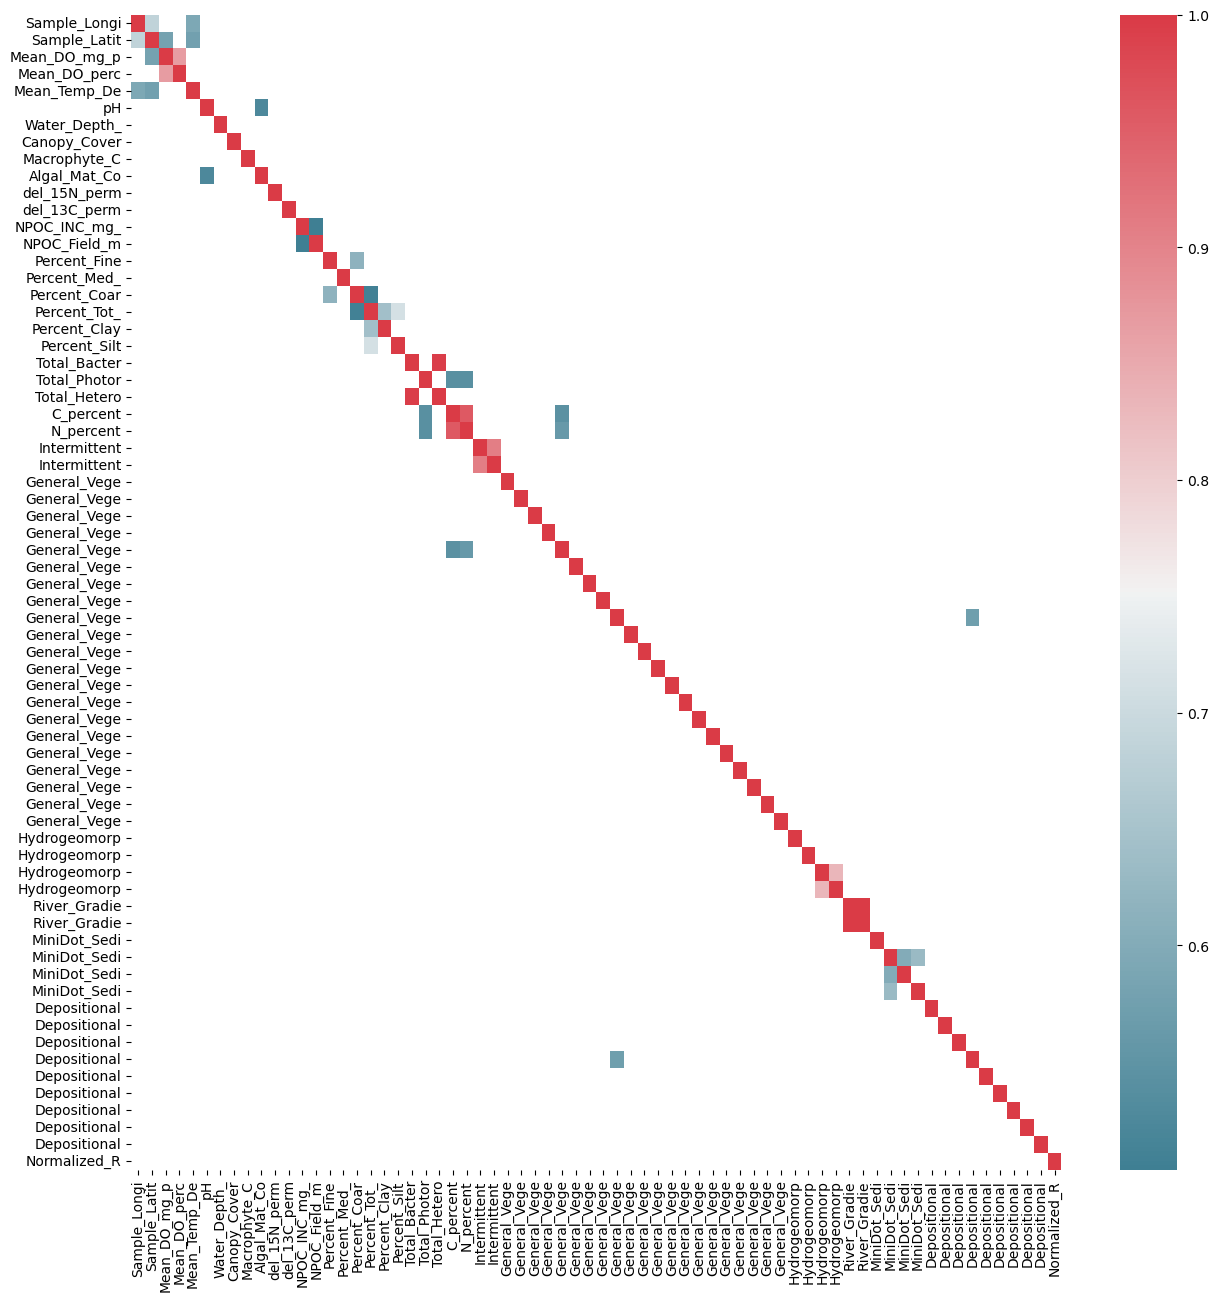

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
short_names = [name[:12] for name in corr.columns]
sns.heatmap(ax=ax, data=np.abs(hot_spots), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))
